# Classifying News Articles
Hello and welcome to our notebook, in this notebook we detail how we trained a BERT transformer model to be able to classify news articles into categories based on political bias. We will then compare BERT against Logistic Regression to see if the BERT Transformer model can match or exceed it in terms of performance and accuracy.

### Dataset
Our data comes from
https://www.kaggle.com/datasets/gandpablo/news-articles-for-political-bias-classification

it is a dataset containing more than 10k news articles, containing a wide variety of topics, collected from major English media sources. It classifies them according to political bias into 5 categories: leaning-left, left, center, right, leaning-right.

### Variables included are as follows:

url: link to the news site

data: publication data

title: headline of the article

site: source of the article

topic: subject category of the news

bias: political bias label

page_text: body of the article

# Section I

## Class Distribution Plot

### Subtask:
Generate a bar chart visualizing the count of each political bias label in the dataset to satisfy the requirement of analyzing class distribution.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("/content/sample_data/bias_clean.csv")

# Calculate the frequency of each label in the 'bias' column
bias_counts = df['bias'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
bias_counts.plot(kind='bar', color='skyblue')

# Add title and labels
plt.title("Class Distribution of Political Bias")
plt.xlabel("Bias Label")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Display the plot
plt.show()

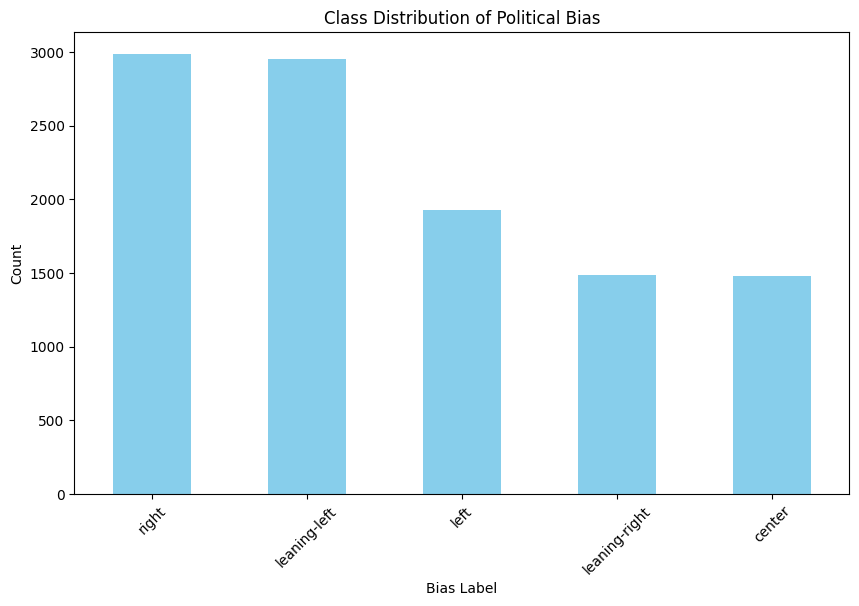

## Article Length Analysis

### Subtask:
Calculate the word count for articles in the 'page_text' column and generate a histogram to analyze the distribution of article lengths.


**Reasoning**:
Calculate the word count for each article and generate a histogram to visualize the distribution of article lengths.



In [ ]:
import matplotlib.pyplot as plt

# Calculate word count for each article
article_lengths = df['page_text'].str.split().str.len()

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(article_lengths, bins=50, color='lightgreen', edgecolor='black')

# Add title and labels
plt.title("Distribution of Article Lengths")
plt.xlabel("Article Length (Word Count)")
plt.ylabel("Frequency")
plt.xlim(0, 10500)

# Display the plot
plt.show()

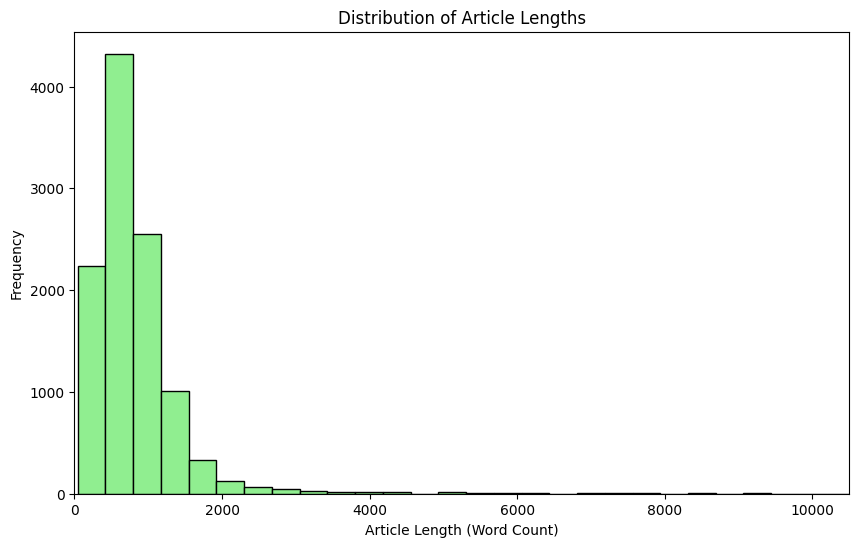

First we'll import torch and BERT, for this we are using bert-base-uncased as well as BertTokenizerFast, this greatly sped up the training of the model.

In [ ]:
#This was for the colab pinging the WANDB server for cloud syncing
import os
os.environ["WANDB_MODE"] = "offline"


import torch
from transformers import BertForSequenceClassification, BertTokenizerFast, Trainer, TrainingArguments

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizerFast.from_pretrained(model_name)

print(f"BERT model '{model_name}' and tokenizer loaded successfully.")

Next we'll use a pandas dataframe to create labels for our bias. In addition we can check if these labels are created, the size of the data, and that all the columns are present.

In [ ]:
from sklearn.preprocessing import LabelEncoder

df['bias'].value_counts()
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['bias'])
num_labels = len(label_encoder.classes_)

num_labels, label_encoder.classes_, df.columns, df.shape

Now that we've loaded our dataset we can proceed to tokenizing our data. for this we used torch.

In [ ]:
from datasets import Dataset

dataset = Dataset.from_pandas(df)
dataset = dataset.train_test_split(test_size=0.1, seed=42)


def tokenize(batch):
  return tokenizer(
      batch['page_text'],
      padding='max_length',
      truncation=True,
      max_length=256
  )


tokenized_dataset = dataset.map(tokenize, batched=True, batch_size=1000)

tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
train_dataset = tokenized_dataset['train']
test_dataset = tokenized_dataset['test']

len(train_dataset), len(test_dataset)


 ### Output

 Map: 100% 9748/9748 [00:37<00:00, 321.90 examples/s]

 Map: 100% 1084/1084 [00:03<00:00, 272.99 examples/s]

 (9748, 1084) Number of training and test articles

#Training

Now that we've tokenized our dataset we can now train BERT over it. For this model we will test over 2 epochs. This was done on Colab using a GPU so it was significantly faster than doing it using a CPU.

In [ ]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

training_args = TrainingArguments(
    output_dir="./bert-bias-model",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_steps=50,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

### Output

| Epoch | Training Loss | Validation Loss |
|-------|---------------|----------------|
| 1     | 1.108400      | 1.089718       |
| 2     | 0.955200      | 0.878829       |
    
  
TrainOutput(global_step=2438, training_loss=1.1512140363234784, metrics={'train_runtime': 1020.9238, 'train_samples_per_second': 19.096, 'train_steps_per_second': 2.388, 'total_flos': 2564875652739072.0, 'train_loss': 1.1512140363234784, 'epoch': 2.0})

Now after that is done we can run our test data set through our trained model. We can observe the model was becoming more accurate, the training and validation loss were both decreasing. From this we can generate a confusion matrix to interpret the accuracy and which articles the model is most confident at categorizing.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

predictions = trainer.predict(test_dataset)
logits = predictions.predictions
pred_labels = logits.argmax(axis=1)
true_labels = predictions.label_ids

accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average='weighted')

print("Accuracy:", accuracy)
print("F1 Score:", f1)

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(cm, display_labels=['center','leaning-left','leaning-right','left','right'])
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("BERT Confusion Matrix")
plt.show()

Accuracy: 0.6660516605166051

F1 Score: 0.6663458108345507

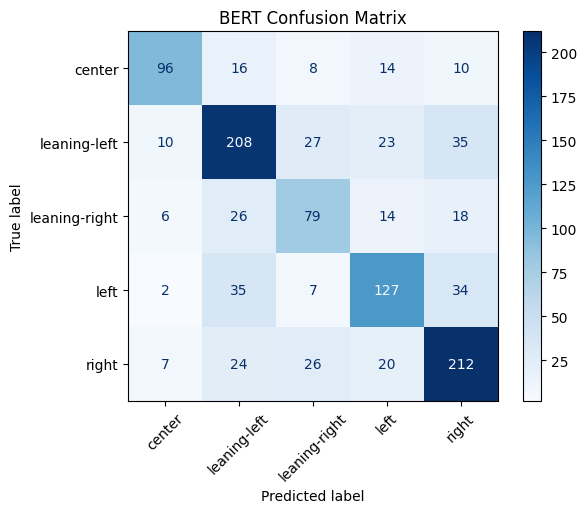

## Results from BERT
Our results found that our model is correct about 66% of the time when given an article. It is most confident in categorizing left-leaning and right articles. This would suggest that these articles share many of the same words. Additionally it would appear that there were more of these groups of articles than the other categories in the test dataset. So based on the true article bias split of the test data the dominant categories might be different.

# Section II
## BERT compared to Logistic Regression
Now that we've trained BERT we can compare it to a Logistic Regression. To do this we will first have to vectorize the text in the articles to train LR over it.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X = vectorizer.fit_transform(df['page_text'])
y  = df['label']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, solver ='saga')
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['center','leaning-left','leaning-right','left','right'])
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

Accuracy: 0.6430

F1 Score: 0.6396

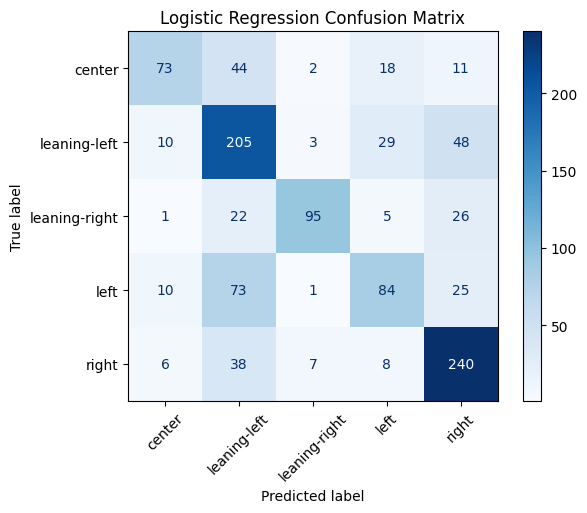

## Results from Logistic Regression

We can see that model performs slightly worse with it being correct about 64% of the time. There also seems to be more clustering of the data into one or two of the untrue predicted labels.

## Hyperparameter Tuning

### Subtask:
Perform a Grid Search with Cross-Validation on the Logistic Regression pipeline to optimize hyperparameters.


**Reasoning**:
Perform hyperparameter tuning using GridSearchCV on a pipeline containing TfidfVectorizer and LogisticRegression to find the optimal C and ngram_range.



In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Split the dataset using raw text
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['page_text'],
    df['label'],
    test_size=0.1,
    random_state=42,
    stratify=df['label']
)

# Create a pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000)),
    ('clf', LogisticRegression(solver='saga', max_iter=1000))
])

# Define parameter grid
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [0.1, 1, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=1)

# Fit the grid search
grid_search.fit(X_train_text, y_train)

# Get the best model
best_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

## Output
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Best Parameters: {'clf__C': 10, 'tfidf__ngram_range': (1, 2)}

Best Cross-Validation Accuracy: 0.6514165620980026


## Error Analysis

### Subtask:
Evaluate the optimized model on the test set and analyze misclassified examples.


**Reasoning**:
Evaluate the model by generating predictions on the test set, calculating accuracy, and inspecting misclassified examples to understand model errors. I will ensure robustness by reconstructing the model with best parameters if it's missing from the environment.



In [ ]:
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Ensure best_model exists (in case it wasn't persisted or listed)
if 'best_model' not in locals():
    print("Re-instantiating best_model with identified best parameters...")
    best_model = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1, 2))),
        ('clf', LogisticRegression(solver='saga', max_iter=1000, C=10))
    ])
    best_model.fit(X_train_text, y_train)

# Helper function to decode labels
if 'label_encoder' in locals():
    def get_label_name(label):
        return label_encoder.inverse_transform([label])[0]
else:
    # Fallback using dataframe if label_encoder is missing
    label_map = df[['label', 'bias']].drop_duplicates().set_index('label')['bias'].to_dict()
    def get_label_name(label):
        return label_map.get(label, str(label))

# 1. Generate predictions
y_pred = best_model.predict(X_test_text)

# 2. Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {accuracy:.4f}")

# 3. Identify misclassified indices
# Create a DataFrame for easier handling of indices and text
analysis_df = pd.DataFrame({
    'text': X_test_text,
    'true_label': y_test,
    'pred_label': y_pred
})

# Filter for errors
misclassified = analysis_df[analysis_df['true_label'] != analysis_df['pred_label']]

# 4 & 5. Display first 3 misclassified examples
print("\n--- Misclassified Examples Analysis ---")
for i, (index, row) in enumerate(misclassified.head(3).iterrows()):
    print(f"\nExample {i+1}:")
    print(f"Text snippet: {row['text'][:300]}...")
    print(f"True Label: {get_label_name(int(row['true_label']))}")
    print(f"Predicted Label: {get_label_name(int(row['pred_label']))}")

## Output
Test Set Accuracy: 0.6707

--- Misclassified Examples Analysis ---

Example 1:
Text snippet: 'Today we can't breathe.' DOJ will not bring civil rights charge against NYPD officer in death of Eric Garner
WASHINGTON – The Justice Department will not bring federal charges against a New York City police officer over the death of Eric Garner during a chaotic arrest that ignited nationwide protes...
True Label: leaning-left
Predicted Label: left

Example 2:
Text snippet: Images and videos posted on social media Sunday afternoon showed hundreds of migrants from the leading Central American caravan pushing past Mexican riot police and rushing the border at the port of entry in San Ysidro, Calif., in a major test for both U.S. border authorities and Mexican officials.
...
True Label: right
Predicted Label: leaning-left

Example 3:
Text snippet: As House GOP leader Kevin McCarthy forges ahead in his quest to secure 218 votes to be the next speaker of the House, he is vowing to take a hard line in the future against any GOP senator who votes to pass the $1.7 trillion spending bill this week.
McCarthy wrote on Twitter, “when I’m Speaker,” bil...
True Label: leaning-left
Predicted Label: left


# Section III

### Includes:
A comprehensive summary of the exploratory data analysis, hyperparameter tuning results, and error analysis findings. Conclusion/Observations, and Contributions.


## Summary:

We can start with a brief summary of the project and what we accomplished.

*   Started by defining and importing our news dataset
*   Examined the difference in the data
*   Tokenized the data and formed the train and test datasets
*   Set up and Trained BERT over the training set for 2 epochs
*   Evaluated the test dataset over the now trained BERT model and generated a Confusion matrix
*   Set up and trained a Logistic Regression model over the training set
*   Evaluated the test dataset over the LR model and generated a confusion matrix
*   Compared the two models
*   Highlighted hyperparameter optimizations

From the evalation of the models it's apparent that the BERT model is better at classifying the news articles in comparison to the LR. However, this came with significant tradeoffs. BERT was significantly slower to train and required far more resources when compared to the speed of the LR, and while it is more accurate, it's not significantly more accurate than the LR model and is still around 66% accuracy. This suggests that there is definitely room for optimization in the way we conducted the project which is discussed below.


### Q&A

**What were the optimal hyperparameters found for the Logistic Regression model?**
The Grid Search determined the best hyperparameters to be a regularization strength of `C=10` and an `ngram_range` of `(1, 2)` for the TF-IDF Vectorizer.

**How did the optimized model perform on the test set?**
The optimized model achieved a test set accuracy of approximately **67.07%**.

**What patterns were observed in the misclassified examples?**
The error analysis highlighted confusion between adjacent ideological categories. For instance, articles labeled "leaning-left" were misclassified as "left," and "right" leaning articles were sometimes misclassified as "leaning-left," indicating difficulty in distinguishing the intensity of bias.

### Data Analysis Key Findings

*   **Exploratory Data Analysis (EDA):**
    *   Successfully visualized the frequency of political bias labels using a bar chart to understand class balance.
    *   Analyzed article lengths by calculating word counts and generating a histogram with 50 bins, revealing the distribution of text length across the dataset.
*   **Hyperparameter Tuning:**
    *   Performed a 3-fold Cross-Validation Grid Search on a Logistic Regression pipeline using `TfidfVectorizer` (max features: 20,000).
    *   Evaluated `C` values of [0.1, 1, 10] and `ngram_range` of [(1, 1), (1, 2)].
    *   The best cross-validation score recorded was **0.6514**.
*   **Model Evaluation:**
    *   The final model, re-instantiated with `C=10` and `ngram_range=(1, 2)`, yielded a **Test Set Accuracy of 0.6707**.
    *   Specific error examples showed the model struggles with nuance, such as misclassifying an article about DOJ charges (True: "leaning-left") as "left" and an article about a migrant caravan (True: "right") as "leaning-left."


## Conclusion/Observations

From the evalation of the models it's apparent that the BERT model is better at classifying the news articles in comparison to the LR. However, this came with significant tradeoffs. BERT was significantly slower to train and required far more resources when compared to the speed of the LR, and while it is more accurate, it's not significantly more accurate than the LR model and is still around 66% accuracy. This suggests that there is definitely room for optimization in the way we conducted the project which is discussed below.

### Potential Issues

Number of iterations over the training set for BERT, this was mostly due to the duration the training was taking, a higher number of epochs (3-4) might make the model more accurate before it starts to overfit.

Using BERT to make embeddings for the LR might result in a significant increase in model accuracy. For the sake of comparison that was not explored to highlight the difference and see if BERT having the ability to "understand" text would influence it's classification over LR.

### Reflection/Next Steps

Spencer Williams - The project did meet the requirements for what I was setting out to do. I was able to successfully train BERT to be able to predict article bias with a >50 accurracy. It also suggests that there is a lot I could do to make it even more accurate. I've been mostly unfamiliar with deep learning and this was a good introduction to using that practically. Especially, since this was using highly variational text articles compared to numbers.  it's greatly increased my understanding of BERT and how I could use it versus other models. On top of that the understanding that I can implement BERT into other models to improve accuracy.

Hoguer Prieto - The confusion between "leaning" and "extreme" labels (e.g., Leaning Left vs. Left) suggests that the linguistic boundaries between these classes are subtle. Merging these into a 3-class system (Left, Center, Right) could likely increase model accuracy significantly.
Feature Engineering: Since bigrams (`ngram_range=(1, 2)`) improved performance, exploring trigrams or more advanced semantic embeddings (like BERT or Word2Vec) might help capture the context required to distinguish subtle bias levels better than a bag-of-words approach.







## Contributions

### Spencer Williams

I did the training of the transformer model and the analysis of it compared to the other model. All of the formatting and cleaning it up at the end. Wrote some of the summary, the conclusion, and introduction.

### Hoguer Prieto

Examined and chose the data, as well as highlighted difference in the data. Examined and showed examples of misclassifed data and created the summary.